# Students Do: Sentiment Analysis - RNNs Vs. Vader

In this activity, students will use two different models to score sentiment. The goal is to put the performance metrics and techniques students have learned into action to decide which model performs better between VADER and RNN LSTM.

In [3]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf

%matplotlib inline

In [4]:
# Set the random seed for reproducibility
from numpy.random import seed
seed(1)

from tensorflow import random
random.set_seed(2)

## The DataSet: IMBD Movie Reviews

The dataset provided contains `25000` movie reviews based on [the data shared by Andrew Mass from Stanford University](http://ai.stanford.edu/~amaas/data/sentiment/). This dataset is intended to serve as a benchmark for sentiment classification, that's why it's suitable for this activity.

The movie reviews are split evenly into `12500` positive reviews and `12500` negative reviews. The reviews are not attached to a particular movie, and this is not crucial for our models' comparison since we would like to benchmark which model performs better to score sentiment.

You can learn more about this dataset in the following research paper: [Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng and Christopher Potts. (2011). **Learning Word Vectors for Sentiment Analysis**. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011)](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf).

## Instructions

### Data Preprocessing

Load the provided dataset in a Pandas DataFrame entitled `df_reviews` and show the first `10` records.

In [5]:
# Load the dataset
movie_comments_df = pd.read_csv(r"C:\Users\TribThapa\Desktop\Thapa\ResearchFellow\Courses\FinTech_Bootcamp_MonashUni2021\monu-mel-virt-fin-pt-05-2021-u-c\Activities\Week 14\3\03-Stu_RNN_Vader\Resources\movie_comments.csv")

movie_comments_df.head()

,comment,sentiment
0,A question for all you girls out there : If a ...,0
1,It was almost worth sitting through this entir...,0
2,One of the weaker Carry On adventures sees Sid...,0
3,"First of all, I think the below comment is unw...",1
4,This is by far the worst film I have seen in m...,0


Create the features set `X` and the target vector `y` by assigning the `comment` column to `X` and the `sentiment` column to `y`.movie_comments_df

In [6]:
# Create the features set (X) and the target vector (y)
X = movie_comments_df["comment"].values

y = movie_comments_df["sentiment"].values

Use the `train_test_split` method from `sklearn` to create the training, testing, and validation sets.

In [7]:
# Create the train, test, and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=78)

In [8]:
# Create the validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  random_state=78)

## Scoring Sentiment Using VADER

In this section, you will use VADER sentiment from the `nltk` library to score the sentiment of the testing set. Later, you will assess model performance using metrics such as accuracy, precision, recall, among others.

In [9]:
# Import the libraries for sentiment scoring using Vader
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Start by downloading or updating the VADER lexicon.

In [10]:
# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\TribThapa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Create an instance of the `SentimentIntensityAnalyzer` and name it `analyzer`.

In [11]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

Define two lists to store the sentiment scoring results as follows:

* `y_vader_pred` will save the scored sentiment, `1` for positive or `0` for negative.

* `y_vader_prob` will store the normalized value of the `pos` polarity score.

In [12]:
# Define two lists to store vader sentiment scoring
y_vader_pred = []
y_vader_prob = []

Create a `for` loop to iterate across all the comments in the `X` set and score the sentiment of each review comment. Update the two lists for sentiment scores as follows:

* Append the `pos` score to the `y_vader_prob`, you will normalize this list's values later.

* To score a review comment as positive or negative, we will use the `compound` polarity score; as you may remember from the NLP unit, the `compound` score ranges between `-1` (most extreme negative) and `+1` (most extreme positive). Following the recommendations from [this research paper](https://scholar.smu.edu/cgi/viewcontent.cgi?article=1051&context=datasciencereview), we will define a threshold of `0.1` to label a review as positive, if the `compound` score is greater than or equal to `0.1`, the review comment will be positive (append `1` to `y_vader_pred`); if the `compound` score is below `0.1`, the review comment will be negative (append `0` to `y_vader_pred`).

In [13]:
X_test.shape

(6250,)

In [14]:
# Score sentiment of test set using Vader
for comment in X_test:
    sentiment = analyzer.polarity_scores(comment)
    compound = sentiment["compound"]
    pos = sentiment["pos"]
    neu = sentiment["neu"]
    neg = sentiment["neg"]
    
    y_vader_prob.append(pos)
    
    result = 0
    if compound >= 0.1:
        result = 1
        y_vader_pred.append(result)
    elif compound < 0.1:
        result = 0
        y_vader_pred.append(result)

In [15]:
print(f"y_vader_pred length: {len(y_vader_pred)}")
print()
print(f"y_vader_prob length: {len(y_vader_prob)}")

y_vader_pred length: 6250

y_vader_prob length: 6250


In [16]:
print(f"y_vader_pred: {y_vader_pred[:5]}")
print()
print(f"y_vader_prob: {y_vader_prob[:5]}")
print()

y_vader_pred: [0, 1, 0, 1, 1]

y_vader_prob: [0.095, 0.349, 0.06, 0.146, 0.257]



You will use the values from the `pos` polarity score to plot the ROC curve; we will consider the `pos` score as the probability of a review comment to be positive. To plot the ROC curve, these probabilities should range from `0` to `1`, so the values of the `y_vader_prob` list will be normalized using [min-max normalization](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization)).

* Normalize the data stored in the `y_vader_prob` list and save the resulting normalized values in a variable called `y_vader_prob_norm`.

_Hint:_ To normalize the data, you can use the `MinMaxScaler` method from `sklearn`, or you can code the min-max normalization formula using a comprehension list.

In [17]:
# Option 1: Normalizing data using MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

y_vader_prob = np.reshape(y_vader_prob, (-1, 1)).T

scaler = MinMaxScaler()

scaler.fit(y_vader_prob)

y_vader_prob_norm = scaler.transform(y_vader_prob)

In [18]:
y_vader_prob_norm

array([[0., 0., 0., ..., 0., 0., 0.]])

In [19]:
# Option 2: Using a comprehension list


## Scoring Sentiment Using RNN LSTM

In this section, you will build an RNN LSTM model to score the sentiment of the review comments. You will fit the model using the training and validations sets, and finally, you will get some predictions using the testing set for further performance assessment and comparison with VADER.

Start encoding the review comments using the `Tokenizer` method from Keras.

In [20]:
# Import the Tokenizer method from Keras
from tensorflow.keras.preprocessing.text import Tokenizer

Create an instance of the `Tokenizer`, and fit it with all the review comments that you stored in `X`.

In [21]:
# Create an instance of the Tokenizer and fit it with the X text data
tokenizer = Tokenizer(lower=True)

tokenizer.fit_on_texts(X)

For testing proposes, print the first five elements of the encoded vocabulary created with the `Tokenizer`.

In [22]:
# Print the first five elements of the encoded vocabulary
for token in list(tokenizer.word_index)[:5]:
    print(f"Word: {token}, Token: {tokenizer.word_index[token]}")

Word: the, Token: 1
Word: and, Token: 2
Word: a, Token: 3
Word: of, Token: 4
Word: to, Token: 5


To fit the RNN LSTM model for sentiment scoring, the text data in `X` should be encoded as sequences. Use the `text_to_sequence()` method of the `tokenizer` to transform the text data to numerical sequences and save the sequences in a variable called `X_seq`.

In [23]:
# Transform the text data to numerical sequences
X_seq = tokenizer.texts_to_sequences(X)

For testing proposes, compare the text representation of a movie review with its numerical representation, by printing the first text review in `X` and the first encoded element in `X_seq`.

In [24]:
# Contrast a sample numerical sequence with its text version
print("**Text comment**")
print({X[0]})

**Text comment**
{'A question for all you girls out there : If a man you`ve never met before accidentally phoned you up on purpose and continued to do so at the most indiscreet moments would you be intrigued by him or so freaked out you`d phone the police ? Yeah that`s what I thought so I couldn`t swallow the idea of Marti Gerrard putting up with the unwarrented attention of Connor Hill<br /><br />***** MILD SPOILERS *****<br /><br />This is a really dumb story . Connor Hill`s wife is murdered and the plot revolves around the question is Connor phoning Marti so he can have an alibi ? But there`s a massive gap in logic here , couldn`t Connor have employed a hit man ? something the prosecution seem to have ignored . And wasn`t there any forensics at the murder scene ? So why does the whole trial rest on Connor phoning Marti at the time of the murder ? Dumb . Dumb . Dumb . And it`s as predictable as it is brainless .<br /><br />My abiding memory of this film is that for someone who made t

In [25]:
print("**Numerical sequence representation**")
print(X_seq[0])

**Numerical sequence representation**
[3, 884, 15, 29, 22, 536, 43, 47, 44, 3, 129, 22, 12997, 112, 1829, 156, 2502, 14896, 22, 53, 20, 1284, 2, 3493, 5, 78, 35, 30, 1, 88, 34701, 385, 59, 22, 27, 3691, 31, 87, 39, 35, 8926, 43, 22, 1092, 1693, 1, 565, 1240, 12, 587, 48, 10, 194, 35, 10, 25242, 827, 6192, 1, 323, 4, 30568, 30569, 1484, 53, 16, 1, 52007, 688, 4, 9259, 2186, 7, 7, 3396, 1025, 7, 7, 11, 6, 3, 63, 989, 62, 9259, 2186, 587, 319, 6, 2016, 2, 1, 111, 3050, 184, 1, 884, 6, 9259, 16816, 30568, 35, 26, 67, 25, 32, 12998, 18, 47, 587, 3, 2553, 7180, 8, 2086, 130, 25242, 827, 9259, 25, 5621, 3, 566, 129, 139, 1, 14897, 303, 5, 25, 3692, 2, 27631, 827, 47, 98, 19499, 30, 1, 585, 133, 35, 135, 124, 1, 223, 3096, 357, 20, 9259, 16816, 30568, 30, 1, 55, 4, 1, 585, 989, 989, 989, 2, 9, 587, 14, 724, 14, 9, 6, 6887, 7, 7, 58, 11585, 1751, 4, 11, 19, 6, 12, 15, 291, 34, 90, 1, 3432, 17633, 30568, 30569, 6, 3, 63, 592, 4416, 30570]


Recall that RNN LSTM models need equal size inputs, so that, pad the sequences stored in `X_pad` up to `140` integers using the `pad_sequences` method from Keras. Store the pad size in a variable called `max_words`.

**Note:** You may use a bigger padding size; however, using a bigger value will increase the time that takes fitting the RNN LSTM model.

In [26]:
# Import the pad_sequences method from Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
# Set the pad size
max_words = 140

# Pad the sequences using the pad_sequences() method
X_pad = pad_sequences(X_seq,
                      maxlen=max_words,
                      padding="post")

### Create the Training, Validation, and Testing Sets

You need to create suitable training, validation, and testing sets for fitting and testing the RNN LSTM model using the encoded review comments. Use the `train_test_split` method from `sklearn` to create these sets.

In [28]:
# Creating training, validation, and testing sets using the encoded data
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_pad,
                                                                    y,
                                                                    random_state=78)

X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_rnn,
                                                                  y_train_rnn,
                                                                  random_state=78)

### Build and Train the RNN LSTM Model

Remember that we use `Embedding` layers to analyze text data in RNN LSTM models, so this section starts by setting-up some initial variables needed for the RNN LSTM to score sentiment.

As it's defined in the [Embedding layer documentation of the Keras API](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding?version=stable), you should set the `input_dim` parameter to the size of your vocabulary, so we set the `vocabulary_size` variable to the length of the number of words in the `tokenizer` plus `1`.

Also, we define a variable called `embedding_size` to specify how many dimensions will be used to represent each word.

In [29]:
# Import Keras modules for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [30]:
# Model set-up
vocabulary_size = len(tokenizer.word_counts.keys()) + 1
embedding_size = 64

Define an RNN LSTM model as follows:

* _Layer 1:_ Add an `Embedding` layer using the `vocabulary_size` and `embedding_size` variables as the first two parameters, and setting `input_length=max_words` (the same size as the padding).

* _Layer 2:_ Add an LSTM layer with `280` units.

* _Output Layer:_ Add a `Dense` layer with `1` unit and `sigmoid` as activation function.

In [31]:
# Define the LSTM RNN model
model = Sequential()

# Layer 1
model.add(Embedding(vocabulary_size,
                    embedding_size,
                    input_length=max_words))

# Layer 2
model.add(LSTM(units=280))

# Output layer
model.add(Dense(1,
                activation="sigmoid"))

Compile the model using the `binary_crossentropy` loss function, the `adam` optimizer, and fetch the following metrics: Accuracy, True positives, True negatives, False positives, False negatives, Precision, Recall, and AUC.

In [32]:
# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy",
                       tf.keras.metrics.TruePositives(name="tp"),
                       tf.keras.metrics.TrueNegatives(name="tn"),
                       tf.keras.metrics.FalsePositives(name="fp"),
                       tf.keras.metrics.FalseNegatives(name="fn"),
                       tf.keras.metrics.Precision(name="precision"),
                       tf.keras.metrics.Recall(name="recall"),
                       tf.keras.metrics.AUC(name="auc")])

Display the summary of the model using the `summary` method of the model.

In [33]:
# Show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 64)           5669312   
_________________________________________________________________
lstm (LSTM)                  (None, 280)               386400    
_________________________________________________________________
dense (Dense)                (None, 1)                 281       
Total params: 6,055,993
Trainable params: 6,055,993
Non-trainable params: 0
_________________________________________________________________


Train the RNN LSTM model using a batch size equals to `1000` and ten epochs. Remember to set the `validation_data` parameter to use your validation sets.

In [34]:
# Training the model
batch_size = 1000
epochs = 10

training_history = model.fit(X_train_rnn,
                             y_train_rnn,
                             validation_data=(X_val_rnn, y_val_rnn),
                             epochs=epochs,
                             batch_size=batch_size,
                             verbose=1)

Epoch 1/10
15/15 [==============================] - 136s 9s/step - loss: 0.6873 - accuracy: 0.5573 - tp: 5455.0000 - tn: 2382.0000 - fp: 4614.0000 - fn: 1611.0000 - precision: 0.5418 - recall: 0.7720 - auc: 0.5773 - val_loss: 0.6530 - val_accuracy: 0.6950 - val_tp: 2024.0000 - val_tn: 1234.0000 - val_fp: 1105.0000 - val_fn: 325.0000 - val_precision: 0.6469 - val_recall: 0.8616 - val_auc: 0.7451
Epoch 2/10
15/15 [==============================] - 125s 8s/step - loss: 0.6097 - accuracy: 0.7446 - tp: 5737.0000 - tn: 4734.0000 - fp: 2262.0000 - fn: 1329.0000 - precision: 0.7172 - recall: 0.8119 - auc: 0.8044 - val_loss: 0.5351 - val_accuracy: 0.7865 - val_tp: 1862.0000 - val_tn: 1825.0000 - val_fp: 514.0000 - val_fn: 487.0000 - val_precision: 0.7837 - val_recall: 0.7927 - val_auc: 0.8636
Epoch 3/10
15/15 [==============================] - 129s 9s/step - loss: 0.3812 - accuracy: 0.8527 - tp: 6111.0000 - tn: 5880.0000 - fp: 1116.0000 - fn: 955.0000 - precision: 0.8456 - recall: 0.8648 - auc:

Use the `predict_classes` method of your model to score the sentiment setting `batch_size=1000`.

In [35]:
# Predict classes using the testing data
y_rnn_pred = model.predict_classes(X_test_rnn,
                                   batch_size=1000)

C:\Users\TribThapa\anaconda3\envs\mlenv\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## Models Comparison

In this section, you will assess the performance of VADER and the RNN LSTM to score sentiment to decide which one is better.

### Accuracy

Use the `accuracy_score` method from `sklearn` to calculate the accuracy of each model. Display the results for further analysis.

In [36]:
# Accuracy
from sklearn.metrics import accuracy_score

### Confusion Matrix

Scoring the sentiment of the movie reviews as positive or negative is a binary classification problem, so use the `confusion_matrix` method from `sklearn` to calculate the confusion matrix for VADER and the RNN LSTM model.

In [37]:
# Import the confusion_matrix method from sklearn
from sklearn.metrics import confusion_matrix

#### Confusion matrix for VADER

Create the confusion matrix for vader passing the `y_test` and `y_vader_pred` variables as parameters.

In [38]:
# Confusion matrtix metrics from Vader
tn_vader, fp_vader, fn_vader, tp_vader = confusion_matrix(y_test, 
                                                          y_vader_pred).ravel()

# Dataframe to display confusion matrix from Vader
cm_vader_df = pd.DataFrame({"Positive(1)": [f"TP={tp_vader}", f"FP={fp_vader}"],
                            "Negative(0)": [f"FN={fn_vader}", f"TN={tn_vader}"]},
                           index=["Positive(1)", "Negative(0)"])

cm_vader_df.index.name = "Actual"

cm_vader_df.columns.name = "Predicted"

print("Confusion Matrix from Vader")
display(cm_vader_df)

Confusion Matrix from Vader


Predicted,Positive(1),Negative(0)
Actual,,
Positive(1),TP=2606,FN=479
Negative(0),FP=1474,TN=1691


#### Confusion matrix for the RNN LSTM Model

Create the confusion matrix for the RNN LSTM model passing the `y_test_rnn` and `y_rnn_pred` variables as parameters.

In [39]:
# Confusion matrtix metrics from the RNN LSTM model
tn_rnn, fp_rnn, fn_rnn, tp_rnn = confusion_matrix(y_test_rnn,
                                                  y_rnn_pred).ravel()

# Dataframe to display confusion matrix from the RNN LSTM model
cm_rnn_df = pd.DataFrame({"Positive(1)": [f"TP={tp_rnn}", f"FP={fp_rnn}"],
                          "Negative(0)": [f"FN={fn_rnn}", f"TN={tn_rnn}"]},
                         index=["Positive(1)", "Negative(0)"])

cm_rnn_df.index.name = "Actual"

cm_rnn_df.columns.name = "Predicted"

print("Confusion Matrix from the RNN LSTM Model")
display(cm_rnn_df)

Confusion Matrix from the RNN LSTM Model


Predicted,Positive(1),Negative(0)
Actual,,
Positive(1),TP=2678,FN=407
Negative(0),FP=549,TN=2616


### Classification Report

Use the `classification_report` from `sklearn` and generate a report for each model.

In [40]:
# Import the classification_report method from sklearn
from sklearn.metrics import classification_report

In [41]:
# Display classification report for Vader
print(f"Classification Report for Vader: {classification_report(y_vader_pred, y_test)}")

Classification Report for Vader:               precision    recall  f1-score   support

           0       0.53      0.78      0.63      2170
           1       0.84      0.64      0.73      4080

    accuracy                           0.69      6250
   macro avg       0.69      0.71      0.68      6250
weighted avg       0.74      0.69      0.69      6250



In [42]:
# Display classification report for the RNN LSTM Model
print(f"Classification Report for the RNN LSTM Model: {classification_report(y_rnn_pred, y_test_rnn)}")

Classification Report for the RNN LSTM Model:               precision    recall  f1-score   support

           0       0.83      0.87      0.85      3023
           1       0.87      0.83      0.85      3227

    accuracy                           0.85      6250
   macro avg       0.85      0.85      0.85      6250
weighted avg       0.85      0.85      0.85      6250



### Plotting the ROC Curve

In this section, you will visually analyze the performance of both models by plotting the ROC Curve. You will use the `roc_curve` and `auc` methods from `sklearn` to gather the data needed to plot this curve.

In [43]:
# Import the roc_curve and auc metrics from sklearn
from sklearn.metrics import roc_curve, auc

#### ROC Curve - VADER

Use the `roc_curve` method from `sklearn` to calculate the false positives (`fpr`) and true positives (`tpr`) rates passing as parameters the testing target sentiments (`y_test`) and the normalized values of `y_vader_prob` (e.g. `y_vader_prob_norm`).

In [44]:
# Data for ROC Curve - VADER
fpr_test_vader, tpr_test_vader, thresholds_test_vader = roc_curve(y_test, 
                                                                  y_vader_pred)

After calculating the `fpr` and `tpr` for VADER, use the `auc` method of `sklearn` to calculate the AUC for VADER. Round the final result up to `4` decimals.

In [45]:
# AUC for VADER
auc_test_vader = round(auc(fpr_test_vader,
                           tpr_test_vader), 4)

Once you gather all the data needed to plot the ROC curve, create a DataFrtpr_test_vader the `fpr` and `tpr` data from VADER.

In [46]:
# Dataframe to plot ROC Curve for VADER
roc_df_test_vader = pd.DataFrame({"FPR Test Vader": fpr_test_vader,
                                  "TPR Test Vader": tpr_test_vader})

roc_df_test_vader.head()

,FPR Test Vader,TPR Test Vader
0,0.000000,0.000000
1,0.465719,0.844733
2,1.000000,1.000000


Using the `plot()` method of the DataFrame, plot the ROC Curve in red color and show the AUC value in the plot title.

_Hint:_ You can pass `xlim=([-0.05, 1.05])` as a parameter to the `plot()` method to better adjust the curve.

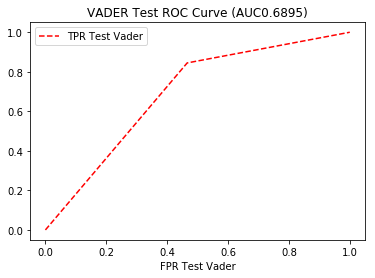

In [47]:
roc_df_test_vader.plot(x="FPR Test Vader",
                       y="TPR Test Vader",
                       xlim=([-0.05, 1.05]),
                       color='red',
                       style='--',
                       title=f"VADER Test ROC Curve (AUC{auc_test_vader})")

#### ROC Curve RNN LSTM

Use the `predict()` method from the RNN LSTM model to predict the sentiment of the testing data `X_test_rnn`. Set `batch_size=1000` to speed up the predictions and store the results in a variable called `test_predictions_rnn`.

In [48]:
# Making predictions to feed the roc_curve module
test_predictions_rnn = model.predict(X_test_rnn, batch_size=1000)

Use the `roc_curve` method from `sklearn` to calculate the false positives (`fpr`) and true positives (`tpr`) rates passing as parameters the testing target sentiments (`y_test_rnn`) and the predictions you compute using the testing data (`test_predictions_rnn`).

In [49]:
# Data for ROC Curve - RNN LSTM Model
fpr_test_rnn, tpr_test_rnn, thresholds_test_rnn = roc_curve(y_test_rnn, test_predictions_rnn)

After calculating the `fpr` and `tpr` for the RNN LSTM Model, use the `auc` method of `sklearn` to calculate the AUC for this model. Round the final result up to `4` decimals.

In [50]:
# AUC for the RNN LSTM Model
auc_test_rnn = round(auc(fpr_test_rnn, tpr_test_rnn), 4)

Once you gather all the data needed to plot the ROC curve, create a DataFrame with the `fpr` and `tpr` data from the RNN LSTM model.

In [51]:
# Dataframe to plot ROC Curve for the RNN LSTM model
roc_df_test_rnn = pd.DataFrame({"FPR Test RNN": fpr_test_rnn,
                                "TPR Test RNN": tpr_test_rnn})

roc_df_test_rnn.head()

,FPR Test RNN,TPR Test RNN
0,0.000000,0.000000
1,0.000000,0.000324
2,0.000000,0.002269
3,0.000316,0.002269
4,0.000316,0.008428


Using the `plot()` method of the DataFrame, plot the ROC Curve in blue color and show the AUC value in the plot title.

_Hint:_ You can pass `xlim=([-0.05, 1.05])` as a parameter to the `plot()` method to better adjust the curve.

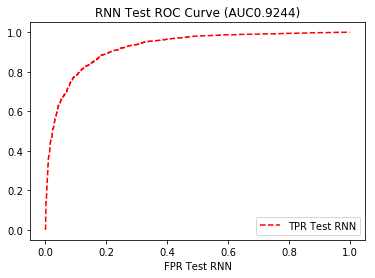

In [52]:
roc_df_test_rnn.plot(x="FPR Test RNN",
                     y = "TPR Test RNN",
                     xlim=([-0.05, 1.05]),
                     color='red',
                     style='--',
                     title=f"RNN Test ROC Curve (AUC{auc_test_rnn})")

## Results Analysis and Conclusions

Review all the metrics you computed, evaluate the ROC curve plots, and the AUC values to answer the following question:

* Which model performed best scoring sentiments?

    RNN is better as its AUC is close to 1 (0.9244) as opposed to VADER's AUC (0.6895). Also, RNN has a higher F1 score suggestin Precision and Recall are better for RNN as opposed to VADER. 